# Score matching flow

In [4]:
%load_ext autoreload
from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import matplotlib
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models
import flows

from jax.experimental import optimizers

key = random.PRNGKey(0)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Main

In [50]:
%autoreload

In [51]:
d = 50
variances = np.logspace(-2, 0, num=d)
proposal = distributions.Gaussian(np.zeros(d), np.ones(d))
target = distributions.Gaussian(np.zeros(d), variances)
setup = distributions.Setup(target, proposal)

In [52]:
n_steps = 2000
noise = 0
particle_lr = 1e-2
n_particles = 1000
key, subkey = random.split(key)
neural_learner, neural_particles, err1 = flows.neural_score_flow(subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=noise, sizes=[32, 32, d], patience=0)
# svgd_gradient, svgd_particles, err2    = flows.svgd_flow(        subkey, setup, n_particles=100, n_steps=n_steps, particle_lr=particle_lr, noise_level=0., scaled=True,  bandwidth=None)
# sgld_gradient, sgld_particles, err3    = flows.sgld_flow(        subkey, setup, n_particles=n_particles, n_steps=n_steps, particle_lr=particle_lr, noise_level=1.)

100%|██████████| 2000/2000 [10:04<00:00,  3.31it/s]


In [53]:
neural_learner.rundata.keys()

dict_keys(['train_steps', 'gradient_norms', 'step_counter', 'training_div', 'training_l2_norm', 'training_lam_term', 'training_loss', 'validation_div', 'validation_l2_norm', 'validation_lam_term', 'validation_loss', 'model_params'])

# Rundata

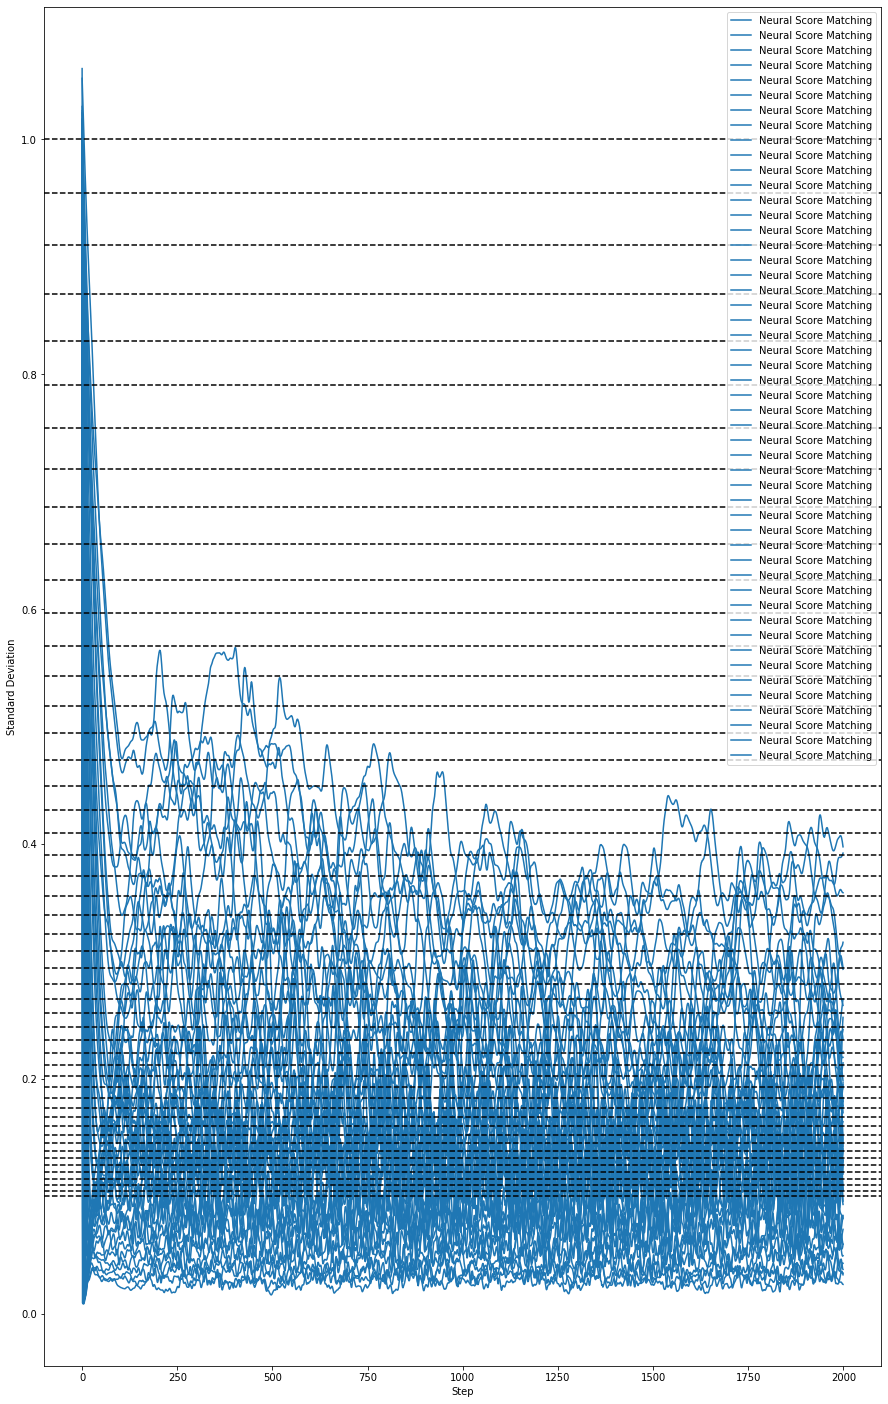

In [54]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[15, 25])
# plt.ylim((0, 5))
stdneur = np.array(neural_particles.rundata["training_std"])
# stdsvgd = svgd_particles.rundata["training_std"]
# stdsgld = sgld_particles.rundata["training_std"]


# plt.plot(onp.mean(neural_particles.rundata["validation_std"], axis=1), color="blue", label="Neural Score Matching: Validation particles")
plt.plot(stdneur, color="tab:blue", label="Neural Score Matching")
# plt.plot(stdsvgd, color="tab:orange", label="SVGD")
# plt.plot(stdsgld, color="tab:green", label="SGLD")

[plt.axhline(y=y, color="black", linestyle="--") for y in np.sqrt(variances)]

plt.ylabel("Standard Deviation")
plt.xlabel("Step")

plt.legend()
# plt.yscale("log")

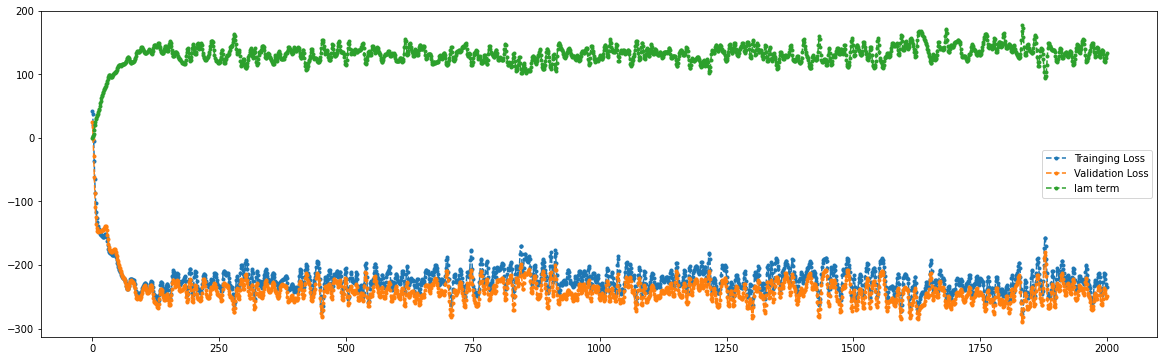

In [55]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(neural_learner.rundata["training_loss"], "--.", label="Trainging Loss")
plt.plot(neural_learner.rundata["validation_loss"], "--.", label="Validation Loss")
plt.plot(neural_learner.rundata["training_lam_term"], "--.", label="lam term")


# plt.plot(neural_learner.rundata["test_loss"], "--.", label="Test Loss")
# plt.ylim(-100, 100)
plt.legend()

In [56]:
neural_learner.rundata.keys()

dict_keys(['train_steps', 'gradient_norms', 'step_counter', 'training_div', 'training_l2_norm', 'training_lam_term', 'training_loss', 'validation_div', 'validation_l2_norm', 'validation_lam_term', 'validation_loss', 'model_params'])

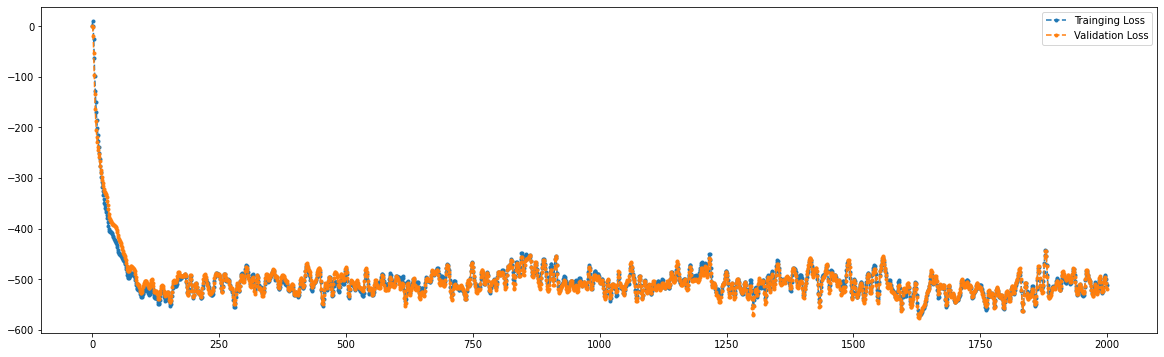

In [ ]:
%matplotlib inline
plt.subplots(figsize=[20, 6])
plt.plot(neural_learner.rundata["training_div"], "--.", label="Trainging Loss")
plt.plot(neural_learner.rundata["validation_div"], "--.", label="Validation Loss")
# plt.plot(neural_learner.rundata["test_loss"], "--.", label="Test Loss")
# plt.ylim(-100, 100)
plt.legend()

In [209]:
# get final particles
target_cov = target.cov
final_particles_list = []
for p in [neural_particles, svgd_particles, sgld_particles]:
    particles, *_ = p.get_params(split_by_group=True)
    final_particles_list.append(particles)
covs  = [target.cov] + [np.cov(p, rowvar=False) for p in final_particles_list]
titles = ["True", "neural", "svgd", "sgld"]
neural_final, svgd_final, sgld_final = final_particles_list

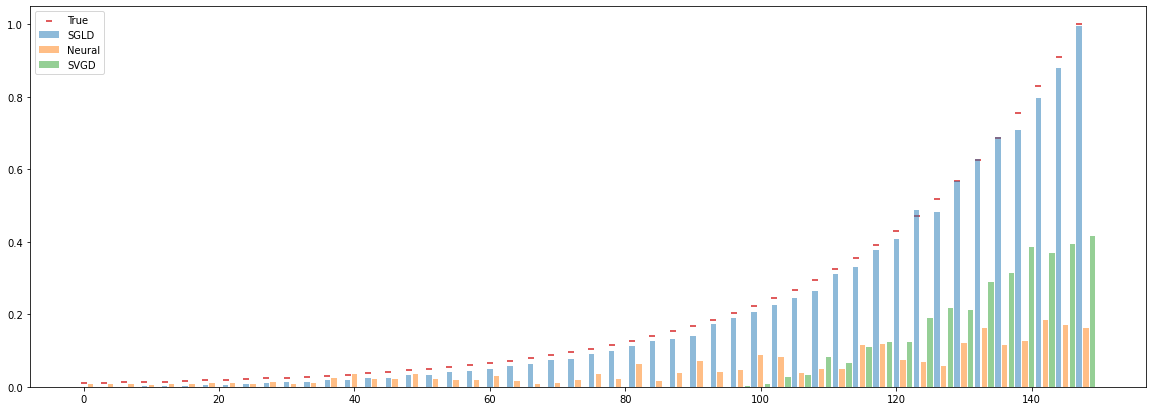

In [219]:
plt.subplots(figsize=[20, 7])
num=3
grid = np.arange(0, 50*num, step=num)

plt.bar(grid,   np.var(sgld_final, axis=0), alpha=0.5, label="SGLD")
plt.bar(grid+1, np.var(neural_final, axis=0), alpha=0.5, label="Neural")
plt.bar(grid+2, np.var(svgd_final, axis=0), alpha=0.5, label="SVGD")

plt.scatter(grid, variances, marker="_", label="True")
plt.legend()

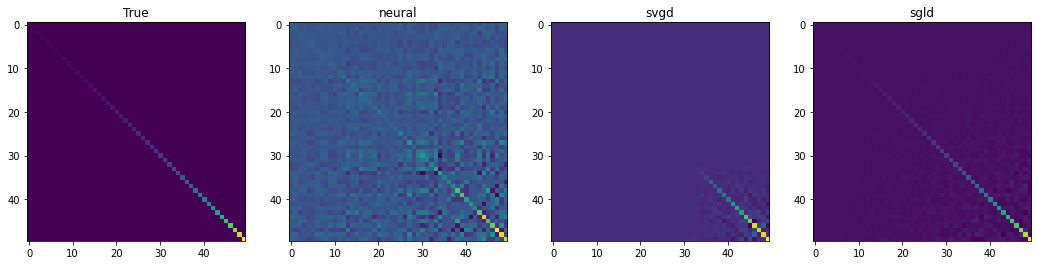

In [211]:
fig, axs = plt.subplots(1, 4, figsize=[18, 5])
axs = axs.flatten()
for ax, cov, title in zip(axs, covs, titles):
    ax.imshow(cov)
    ax.set_title(title)

## plot learned gradient (projection)

In [212]:
slice_idx = [40, 41]

In [220]:
particles, _ = neural_particles.get_params(split_by_group=True)
# _, particles = neural_particles.get_params(split_by_group=True)
# x0 = particles[0]
x0 = np.zeros(d)

def sliced_sq(x):
    """function (2,) to (2,)"""
    xs_nd = index_update(x0, slice_idx, x)
    score_fn = neural_learner.get_score(init_particles=particles)
    vec_nd = score_fn(xs_nd)
    return vec_nd[slice_idx]

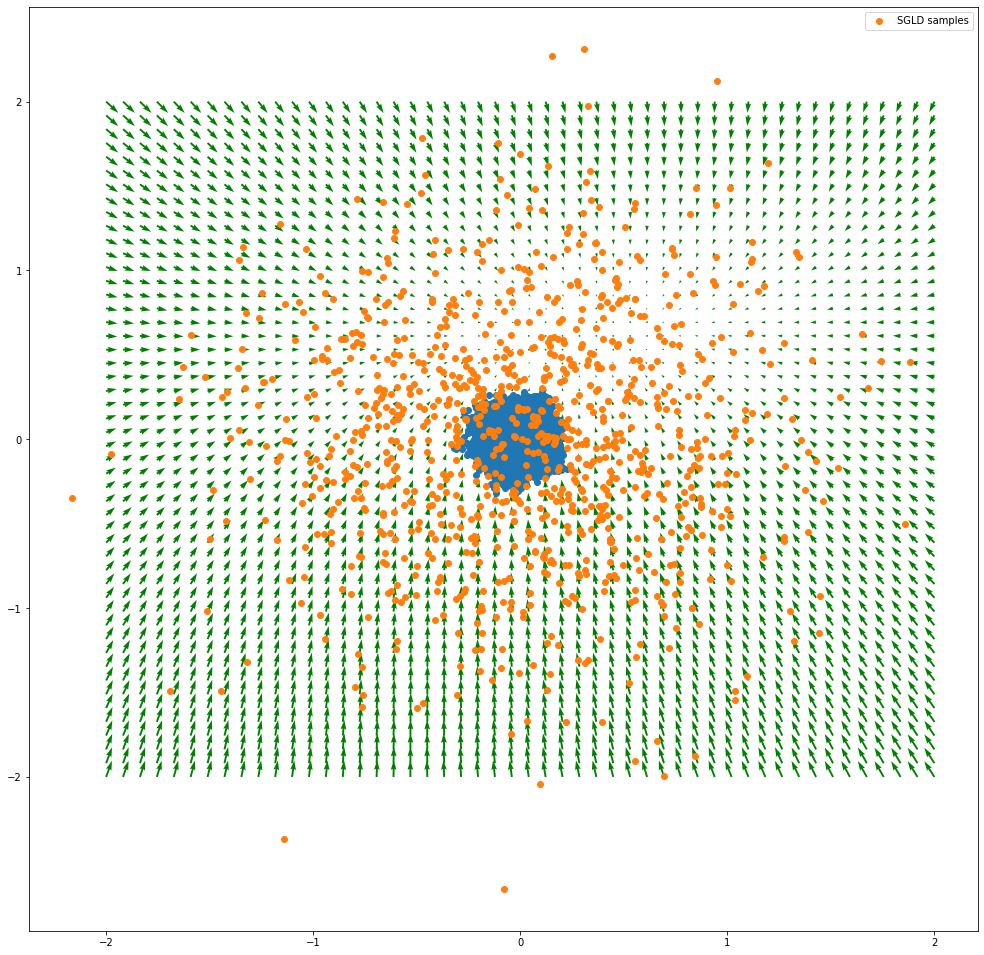

In [221]:
fig, ax = plt.subplots(figsize=[17, 17])
lims=(-2, 2)
# ax.set(xlim=lims, ylim=lims)
plot.plot_gradient_field(vmap(sliced_sq), ax, lims=lims)
plot.scatter(particles[:, :2])
plot.scatter(final_particles_list[2][:, slice_idx], label="SGLD samples")
plt.legend()

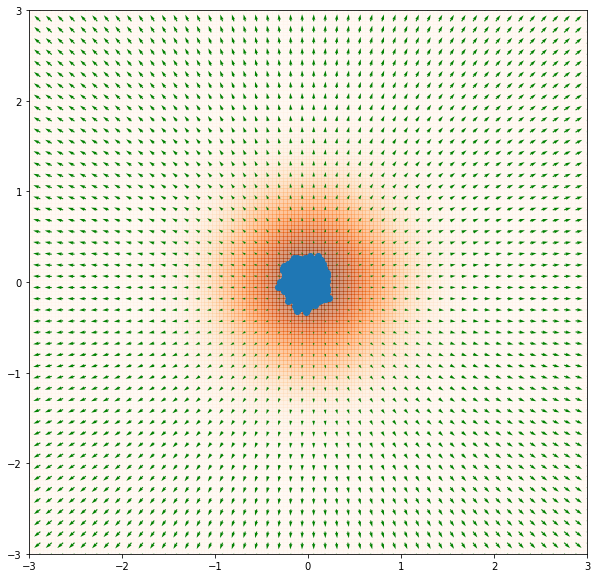

In [222]:
%matplotlib inline
fig, ax = plt.subplots(figsize=[10, 10])
# lims=(-1/4, 1/4)
lims=(-3, 3)
ax.set(xlim=lims, ylim=lims)
def sliced_grads(xs):
    """function (n, 2) to (n, 2)"""
    n = len(xs)
    x0s = np.tile(x0, (n, 1)) # shape (n, d)
    xs_nd = index_update(x0s, index[:, 40:42], xs)
#     xs_nd = np.concatenate([xs, x0s[:, 2:]], axis=1)
    vec_nd = neural_learner.grads(xs_nd)
    return vec_nd[:, slice_idx]

sliced_target = distributions.Gaussian([0, 0], variances[slice_idx])

plot.plot_fun_2d(sliced_target.pdf, lims=lims, ax=ax, alpha=0.5)
plot.plot_gradient_field(sliced_grads, ax, lims=lims)
plot.scatter(particles[:, :2])



# animation

In [216]:
slice_idx

[40, 41]

In [217]:
variances[slice_idx]

DeviceArray([0.42919347, 0.4714867 ], dtype=float32)

In [218]:
neural_trajectory = np.array(neural_particles.rundata["particles"])
neural_trajectory_sliced = neural_trajectory[:, :100, slice_idx]

KeyError: 'particles'

In [192]:
neural_trajectory_sliced.shape

(1300, 100, 2)

In [193]:
np.var(neural_trajectory[800], axis=0)[slice_idx]

DeviceArray([0.10189286, 0.1133597 ], dtype=float32)

In [201]:
%matplotlib widget
fig, ax = plt.subplots(figsize=[7, 7])
lim=(-3, 3)
ax.set(xlim=lim, ylim=lim)
plot.plot_fun_2d(sliced_target.pdf, lims=lim, ax=ax, alpha=0.5)
plot.animate_array(neural_trajectory_sliced, fig, ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

/home/lauro/code/msc-thesis/svgd/kernel_learning/plot.py:200: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  return ax.pcolormesh(*meshgrid, cmap=cmap, **kwargs)


## metrics

In [128]:
p = svgd_particles.rundata["particles"][-1][svgd_particles.group_idx[0]]
metrics.compute_final_metrics(p, target)

{'emd': DeviceArray(6.6136603, dtype=float32),
 'ksd': DeviceArray(0.24453671, dtype=float32),
 'se_mean': DeviceArray(0.00141502, dtype=float32),
 'se_std': DeviceArray(0.5258726, dtype=float32)}

In [127]:
psvgd, *_ = svgd_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(psvgd, target)

{'emd': DeviceArray(6.5788074, dtype=float32),
 'ksd': DeviceArray(0.62195534, dtype=float32),
 'se_mean': DeviceArray(0.00263662, dtype=float32),
 'se_std': DeviceArray(0.5371729, dtype=float32)}

In [126]:
p, *_ = neural_particles.get_params(split_by_group=True)
metrics.compute_final_metrics(p, target)

{'emd': DeviceArray(8.546496, dtype=float32),
 'ksd': DeviceArray(-2.3841805e-11, dtype=float32),
 'se_mean': DeviceArray(0.06007133, dtype=float32),
 'se_std': DeviceArray(0.01018421, dtype=float32)}

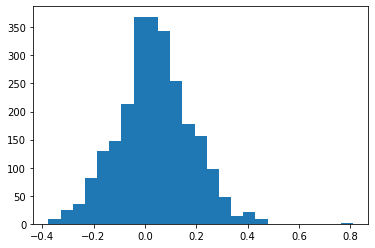

In [122]:
covdiff = np.cov(p) - target.cov
_ = plt.hist(covdiff.flatten(), bins=25)

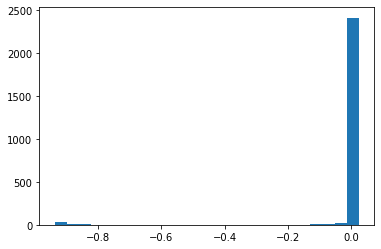

In [123]:
covdiff = np.cov(psvgd) - target.cov
_ = plt.hist(covdiff.flatten(), bins=25)